## Notebook Setup

In [1]:
# importing standard libraries
import tensorflow as tf
print(tf.__version__)
import matplotlib.pylab as plt
import numpy as np

# Importing utils and models
import sys
sys.path.append('../')
from utils import process_path, tf_dataset_generator, get_class_weights
from models import EnetEncoder, TestModel

2.0.0


## Create training test and validation dataset, and get class weights

In [2]:
# creating datasets
train_path = '../dataset/train/images'
val_path = '../dataset/val/images'
test_path = '../dataset/test/images'
train_ds = tf_dataset_generator(train_path)
val_ds = tf_dataset_generator(val_path,train=False,cache=False)
test_ds = tf_dataset_generator(test_path,train=False,cache=False)

# get class weights
# class_weights = get_class_weights(tf_dataset_generator(train_path,train=False,cache=False))

Tensor("args_0:0", shape=(), dtype=string) Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string) Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string) Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("StaticRegexReplace:0", shape=(), dtype=string)


## Test process_path function

In [3]:
process_path('../dataset/train/images/0016E5_06270.png')

../dataset/train/images/0016E5_06270.png tf.Tensor(b'../dataset/train/labels/0016E5_06270.png', shape=(), dtype=string)
tf.Tensor(b'../dataset/train/labels/0016E5_06270.png', shape=(), dtype=string)


(<tf.Tensor: id=190, shape=(360, 480, 3), dtype=float32, numpy=
 array([[[0.31764707, 0.31764707, 0.28235295],
         [0.3137255 , 0.3137255 , 0.2784314 ],
         [0.31764707, 0.31764707, 0.28235295],
         ...,
         [0.6784314 , 0.59607846, 0.5254902 ],
         [0.70980394, 0.6313726 , 0.5411765 ],
         [0.6862745 , 0.6156863 , 0.50980395]],
 
        [[0.2784314 , 0.28235295, 0.2392157 ],
         [0.31764707, 0.32156864, 0.2784314 ],
         [0.3019608 , 0.30588236, 0.2627451 ],
         ...,
         [0.6862745 , 0.6039216 , 0.53333336],
         [0.7058824 , 0.627451  , 0.5372549 ],
         [0.80392164, 0.73333335, 0.627451  ]],
 
        [[0.3019608 , 0.30588236, 0.26666668],
         [0.2901961 , 0.29411766, 0.25490198],
         [0.3254902 , 0.3254902 , 0.28627452],
         ...,
         [0.67058825, 0.5882353 , 0.5176471 ],
         [0.8431373 , 0.76470596, 0.6745098 ],
         [0.7176471 , 0.64705884, 0.5411765 ]],
 
        ...,
 
        [[0.01568628, 0.

## Example (Image,Label) pair from the validation set

In [3]:
for img,iml in train_ds.take(1):
    img_test = img
    iml_test = iml

In [6]:
img_test

<tf.Tensor: id=185, shape=(32, 360, 480, 3), dtype=float32, numpy=
array([[[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.0627451 , 0.0627451 , 0.0627451 ],
         [0.04705883, 0.04705883, 0.04705883],
         ...,
         [0.05882353, 0.07450981, 0.07843138],
         [0.06666667, 0.07058824, 0.07843138],
         [0.06666667, 0.07058824, 0.08627451]],

        [[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.05490196, 0.05490196, 0.05490196],
         [0.05490196, 0.05490196, 0.05490196],
         ...,
         [0.05882353, 0.07450981, 0.07843138],
         [0.07058824, 0.07450981, 0.08235294],
         [0.07450981, 0.07843138, 0.08627451]],

        [[0.05490196, 0.05490196, 0.05490196],
         [0.05490196, 0.05490196, 0.05490196],
         [0.05882353, 0.05882353, 0.05882353],
         ...,
         [0.05882353, 0.07450981, 0.07843138],
         [0.06666667, 0.07058824, 0.07843138],
         [0.0627451 , 0.06666667, 0.07843138]],

        ...,

        [[0.0627451 , 0.0

In [5]:
iml_test

<tf.Tensor: id=186, shape=(32, 360, 480, 3), dtype=float32, numpy=
array([[[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.0627451 , 0.0627451 , 0.0627451 ],
         [0.04705883, 0.04705883, 0.04705883],
         ...,
         [0.05882353, 0.07450981, 0.07843138],
         [0.06666667, 0.07058824, 0.07843138],
         [0.06666667, 0.07058824, 0.08627451]],

        [[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.05490196, 0.05490196, 0.05490196],
         [0.05490196, 0.05490196, 0.05490196],
         ...,
         [0.05882353, 0.07450981, 0.07843138],
         [0.07058824, 0.07450981, 0.08235294],
         [0.07450981, 0.07843138, 0.08627451]],

        [[0.05490196, 0.05490196, 0.05490196],
         [0.05490196, 0.05490196, 0.05490196],
         [0.05882353, 0.05882353, 0.05882353],
         ...,
         [0.05882353, 0.07450981, 0.07843138],
         [0.06666667, 0.07058824, 0.07843138],
         [0.0627451 , 0.06666667, 0.07843138]],

        ...,

        [[0.0627451 , 0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


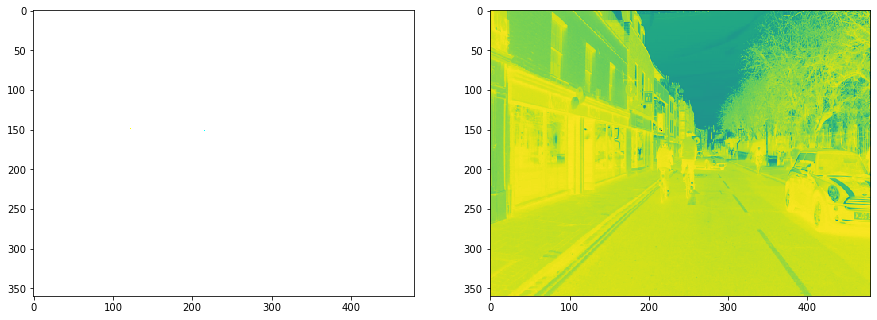

In [3]:
for img,iml in val_ds.take(1):
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(iml.numpy()[:,:,0])

In [7]:
iml_test

<tf.Tensor: id=195, shape=(32, 360, 480, 3), dtype=uint8, numpy=
array([[[[210, 205, 196],
         [164, 158, 145],
         [152, 147, 134],
         ...,
         [138, 128, 128],
         [139, 128, 128],
         [139, 128, 128]],

        [[160, 157, 142],
         [140, 137, 129],
         [156, 153, 142],
         ...,
         [138, 128, 128],
         [138, 128, 128],
         [138, 128, 128]],

        [[166, 162, 145],
         [130, 128, 128],
         [132, 130, 128],
         ...,
         [138, 128, 128],
         [139, 128, 128],
         [139, 128, 128]],

        ...,

        [[205, 205, 204],
         [209, 209, 208],
         [206, 206, 206],
         ...,
         [212, 209, 209],
         [215, 212, 212],
         [217, 213, 213]],

        [[209, 209, 208],
         [207, 207, 206],
         [209, 208, 207],
         ...,
         [214, 211, 211],
         [217, 214, 214],
         [217, 213, 213]],

        [[213, 213, 211],
         [207, 207, 206],
         

## Create the model

In [6]:
Enet = EnetEncoder(C=12)

In [31]:
# compile model
Enet.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

## Fit model

In [ ]:
Enet.fit(x= train_ds,
         epochs=10,
         validation_data=val_ds,
         class_weight=class_weights,
         steps_per_epoch=367//32,
         validation_steps=101//32//5)

Train for 11 steps
Epoch 1/10
 1/11 [=>............................] - ETA: 0s

In [7]:
out_test = Enet(img_test)

In [10]:
print(img_test.shape)
print(out_test.shape)

(32, 360, 480, 3)
(32, 360, 480, 12)


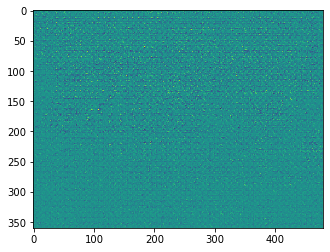

In [14]:
plt.imshow(out_test.numpy()[4,:,:,11])